# Breast Cancer Classification

In [ ]:
import os
from os import listdir
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
from pathlib import Path
import glob
import random
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset 
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import glob
import PIL
import random
random.seed(100)
from matplotlib.image import imread
import tensorflow as tf
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
breast_img_paths = glob.glob('/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/**/*.png', recursive = True)
for img_path in breast_img_paths[:5]:
    print(img_path)

/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-012.png
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-009.png
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-006.png
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-011.png
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-004.png


## Separation of Data

In [3]:
# Types of Tumors
benign = []
malignant = []
# subtypes
A, F, PT, TA = [], [], [], [] # for benign
DC, LC, MC, PC = [], [], [], [] # for malignant

for img in breast_img_paths:
    img_name = Path(img).name
    if img_name[6] == 'A':
        A.append(img)
    elif img_name[6] == 'F':
        F.append(img)
    elif img_name[6] == 'P'and img_name[7] == 'T':
        PT.append(img)
    elif img_name[6] == 'T':
        TA.append(img)
    elif img_name[6] == 'D':
        DC.append(img)
    elif img_name[6] == 'L':
        LC.append(img)
    elif img_name[6] == 'M':
        MC.append(img)
    elif img_name[6] == 'P':
        PC.append(img)
    
    if img_name[4] == 'B':
        benign.append(img)
    else:
        malignant.append(img)
    

In [29]:
print(f"A (Adenosis): {len(A)}")
print(f"F (Fibroadenoma): {len(F)}")
print(f"PT (Phyllodes Tumor): {len(PT)}")
print(f"TA (Tubular Adenoma): {len(TA)}")
print(f"DC (Ductal Carcinoma): {len(DC)}")
print(f"LC (Lobular Carcinoma): {len(LC)}")
print(f"MC (Mucinous Carcinoma): {len(MC)}")
print(f"PC (Papillary Carcinoma): {len(PC)}")

print("Total examples: ", len(breast_img_paths))
print("Number of benign examples", len(benign))
print("Number of malignant examples", len(malignant))

A (Adenosis): 444
F (Fibroadenoma): 1014
PT (Phyllodes Tumor): 453
TA (Tubular Adenoma): 569
DC (Ductal Carcinoma): 3451
LC (Lobular Carcinoma): 626
MC (Mucinous Carcinoma): 792
PC (Papillary Carcinoma): 560
Total examples:  7909
Number of benign examples 2480
Number of malignant examples 5429


## Sampling Images and Pre-Processing

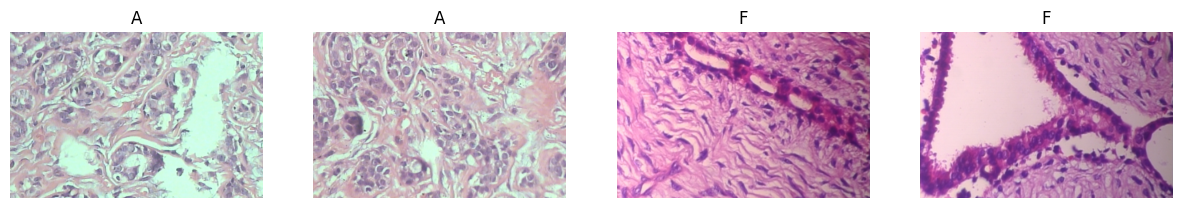

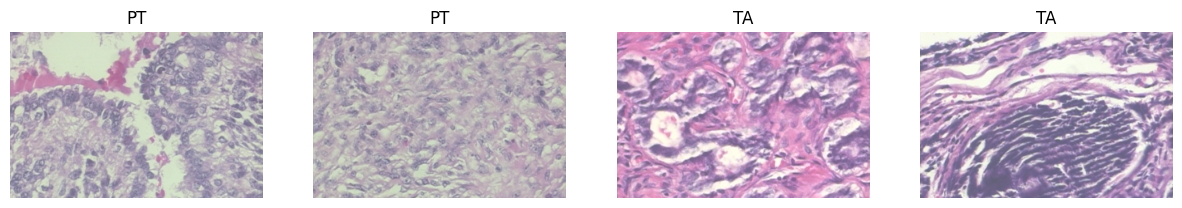

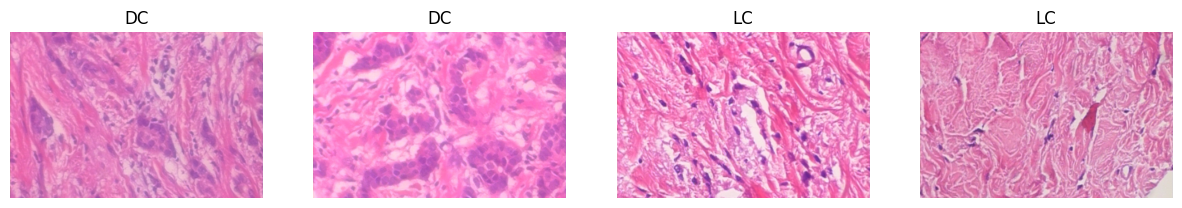

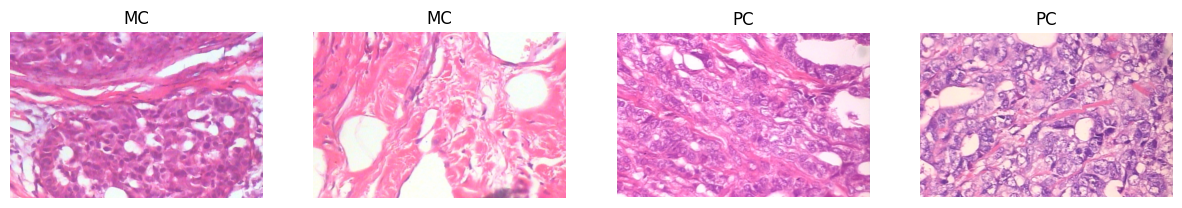

In [6]:
import matplotlib.image as mpimg

def display_images(label1, label2, list1, list2):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for ax, img_path in zip(axes[:2], list1[:2]):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(label1)  
        ax.axis('off')
    
    for ax, img_path in zip(axes[2:], list2[:2]):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(label2)
        ax.axis('off')
    plt.show()

# Display images from each list
display_images("A", "F", A, F)
display_images("PT","TA", PT, TA)
display_images("DC","LC", DC, LC)
display_images("MC","PC", MC, PC)

In [7]:
def load_and_resize_images(img_list, label, size=(128, 128)):
    img_array = []
    for img in img_list:
        image = cv2.imread(img, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        image = image / 255.0
        if label != 4:
            augmented_images = augment_image(image)
            for aug_img in augmented_images:
                image_resized = tf.image.resize(aug_img, size)
                img_array.append([image_resized, label])
        else:
            image_resized = tf.image.resize(image, size)
            img_array.append([image_resized, label])

    return img_array

def augment_image(img):
    augmented_images = []

    augmented_images.append(img)

    for k in [1, 2]:
        rotated_img = tf.image.rot90(img, k=k)
        mirrored_rotated_img = tf.image.flip_left_right(rotated_img)
        augmented_images.append(mirrored_rotated_img)

    return augmented_images

A_imgs  = load_and_resize_images(A, 0)
F_imgs  = load_and_resize_images(F, 1)
PT_imgs  = load_and_resize_images(PT, 2)
TA_imgs = load_and_resize_images(TA, 3)
DC_imgs = load_and_resize_images(DC, 4)
LC_imgs = load_and_resize_images(LC, 5)
MC_imgs = load_and_resize_images(MC, 6)
PC_imgs = load_and_resize_images(PC, 7)

In [8]:
print(f"A (Adenosis): {len(A_imgs)}")
print(f"F (Fibroadenoma): {len(F_imgs)}")
print(f"PT (Phyllodes Tumor): {len(PT_imgs)}")
print(f"TA (Tubular Adenoma): {len(TA_imgs)}")
print(f"DC (Ductal Carcinoma): {len(DC_imgs)}")
print(f"LC (Lobular Carcinoma): {len(LC_imgs)}")
print(f"MC (Mucinous Carcinoma): {len(MC_imgs)}")
print(f"PC (Papillary Carcinoma): {len(PC_imgs)}")

A (Adenosis): 1332
F (Fibroadenoma): 3042
PT (Phyllodes Tumor): 1359
TA (Tubular Adenoma): 1707
DC (Ductal Carcinoma): 3451
LC (Lobular Carcinoma): 1878
MC (Mucinous Carcinoma): 2376
PC (Papillary Carcinoma): 1680


## Undersampling

In [9]:
data_b = A_imgs + F_imgs + PT_imgs + TA_imgs 
data_m = DC_imgs + LC_imgs + MC_imgs + PC_imgs
print("Total number of benign examples:", len(data_b))
print("Total number of malignant examples:", len(data_m))

random.shuffle(data_b)
random.shuffle(data_m)

dataTrain_b, dataTest_b = train_test_split(data_b, test_size=0.2, random_state=0)
dataTrain_b, dataVal_b = train_test_split(dataTrain_b, test_size=0.25, random_state=0)
dataTrain_m, dataTest_m = train_test_split(data_m, test_size=0.2, random_state=0)
dataTrain_m, dataVal_m = train_test_split(dataTrain_m, test_size=0.25, random_state=0)
dataTrain_b_modified = [(image, 0) for image, label in dataTrain_b]
dataTrain_m_modified = [(image, 1) for image, label in dataTrain_m]

dataTrain = dataTrain_b_modified + dataTrain_m_modified
random.shuffle(dataTrain)

dataVal_b_modified = [(image, 0) for image, label in dataVal_b]
dataVal_m_modified = [(image, 1) for image, label in dataVal_m]

dataVal = dataVal_b_modified + dataVal_m_modified
random.shuffle(dataVal)

dataTest_b_modified = [(image, 0) for image, label in dataTest_b]
dataTest_m_modified = [(image, 1) for image, label in dataTest_m]

dataTest = dataTest_b_modified + dataTest_m_modified

print("Total number of examples:", len(dataTrain) + len(dataVal) + len(dataTest))

Total number of benign examples: 7440
Total number of malignant examples: 9385
Total number of examples: 16825


## The Dataset

In [10]:
def create_tf_dataset(img_list, batch_size=64):
    images, labels = zip(*img_list)
    images = np.array(images)  
    labels = np.array(labels)
    
    labels = tf.keras.utils.to_categorical(labels, num_classes=2)
    
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

with tf.device('/GPU:0'):
    train_dataset = create_tf_dataset(dataTrain)
    val_dataset = create_tf_dataset(dataVal)
    test_dataset = create_tf_dataset(dataTest)

# Tumor Classification Model

In [12]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

layer_names = ['block3_sepconv2_act', 'block10_sepconv2_act', 'block13_sepconv2_act']
intermediate_outputs = [base_model.get_layer(name).output for name in layer_names]

intermediate_model = Model(inputs=base_model.input, outputs=intermediate_outputs)

branch_outputs = []
for output in intermediate_outputs:
    x = GlobalAveragePooling2D()(output)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    branch_outputs.append(x)

fusion = Concatenate()(branch_outputs)

x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(fusion)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
final_output = Dense(2, activation='softmax')(x)

binary_model = Model(inputs=base_model.input, outputs=final_output)

optimizer = Adam(learning_rate=0.0001)

binary_model.compile(optimizer=optimizer,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

binary_model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 63, 63, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 63, 63, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 63, 63, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 61, 61, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 61, 61, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 61, 61, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 61, 61, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 61, 61, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 61, 61, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 31, 31, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 31, 31, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 14,713,538 (56.13 MB)

 Trainable params: 14,669,858 (55.96 MB)

 Non-trainable params: 43,680 (170.62 KB)

## Training

In [13]:
import time
start_time = time.time()

history = binary_model.fit(train_dataset,
                           validation_data=val_dataset,
                           epochs=50,
                           callbacks=[early_stopping, reduce_lr])

end_time = time.time()

total_time = end_time - start_time
print(f"Total time taken to train the model: {total_time:.2f} seconds")

Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 97s 334ms/step - accuracy: 0.6911 - loss: 1.1139 - val_accuracy: 0.7632 - val_loss: 0.9701 - learning_rate: 1.0000e-04
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 28s 176ms/step - accuracy: 0.9039 - loss: 0.5706 - val_accuracy: 0.9391 - val_loss: 0.7197 - learning_rate: 1.0000e-04
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 28s 176ms/step - accuracy: 0.9612 - loss: 0.4394 - val_accuracy: 0.9525 - val_loss: 0.5124 - learning_rate: 1.0000e-04
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 28s 177ms/step - accuracy: 0.9808 - loss: 0.3818 - val_accuracy: 0.9596 - val_loss: 0.4152 - learning_rate: 1.0000e-04
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 28s 176ms/step - accuracy: 0.9911 - loss: 0.3438 - val_accuracy: 0.9655 - val_loss: 0.3998 - learning_rate: 1.0000e-04
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 28s 176ms/step - accuracy: 0.9942 - loss: 0.3199 - val_accuracy: 0.9667 - val_loss: 0.3870 - learning_rate: 1.0000e-04
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 28s 17

## Evaluation and Plots

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


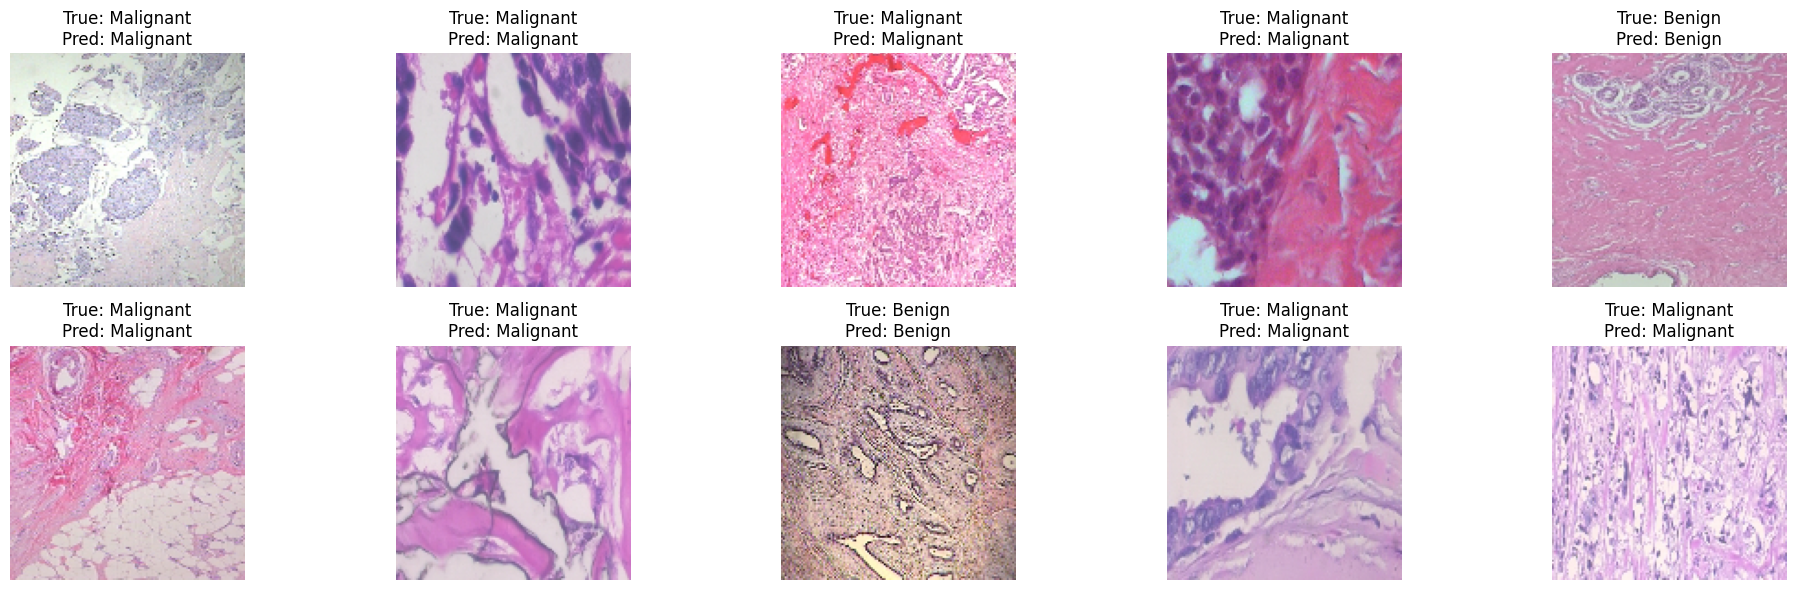

In [14]:
random_indices = random.sample(range(len(dataTest)), 10)
random_images = [dataTest[i][0] for i in random_indices]
true_labels = [dataTest[i][1] for i in random_indices]

image_batch = tf.stack(random_images)
predictions = binary_model.predict(image_batch)

predicted_labels = tf.argmax(predictions, axis=1).numpy()

label_map = {0: "Benign", 1: "Malignant"}

plt.figure(figsize=(20, 6))
for i in range(10):
    img = image_batch[i].numpy()
    img = np.clip(img, 0, 1) 

    plt.subplot(2, 5, i + 1) 
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {label_map[true_labels[i]]}\nPred: {label_map[predicted_labels[i]]}")
plt.tight_layout()
plt.show()


In [15]:
train_loss, train_acc = binary_model.evaluate(train_dataset)
print(f"Train accuracy (binary classification): {train_acc}")
test_loss, test_acc = binary_model.evaluate(test_dataset)
print(f"Test accuracy (binary classification): {test_acc}")

158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 1.0000 - loss: 0.0398
Train accuracy (binary classification): 1.0
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9808 - loss: 0.1075
Test accuracy (binary classification): 0.9839524626731873


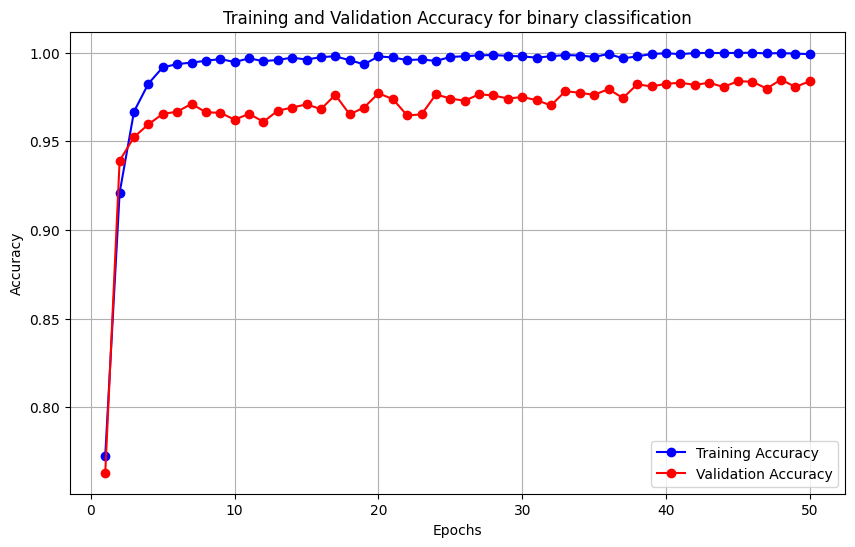

In [16]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for binary classification')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = binary_model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1) 
    true_classes = np.argmax(labels, axis=1)

    y_true.extend(true_classes)
    y_pred.extend(predicted_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9790
Recall: 0.9925
F1 Score: 0.9857


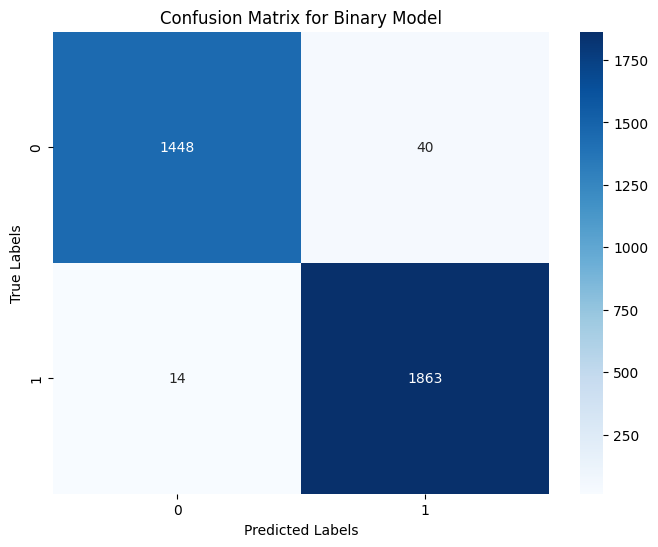

In [18]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix for Binary Model')
plt.show()

# Benign Subtypes Classification

In [13]:
dataTrain_m = [(image, label-4) for image, label in dataTrain_m]
dataVal_m = [(image, label-4) for image, label in dataVal_m]
dataTest_m = [(image, label-4) for image, label in dataTest_m]

In [14]:
def create_tf_dataset(img_list, batch_size=64):
    images, labels = zip(*img_list)
    images = np.array(images)  
    labels = np.array(labels)
    
    labels = tf.keras.utils.to_categorical(labels, num_classes=4)
    
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

dataTrain_b = create_tf_dataset(dataTrain_b)
dataVal_b = create_tf_dataset(dataVal_b)
test_dataset_b = create_tf_dataset(dataTest_b)
dataTrain_m = create_tf_dataset(dataTrain_m)
dataVal_m = create_tf_dataset(dataVal_m)
test_dataset_m = create_tf_dataset(dataTest_m)

## Training 2.0

In [15]:
base_model_b = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

layer_names = ['block3_sepconv2_act', 'block10_sepconv2_act', 'block13_sepconv2_act']
intermediate_outputs = [base_model_b.get_layer(name).output for name in layer_names]

intermediate_model = Model(inputs=base_model_b.input, outputs=intermediate_outputs)

branch_outputs = []
for output in intermediate_outputs:
    x = GlobalAveragePooling2D()(output)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    branch_outputs.append(x)

fusion = Concatenate()(branch_outputs)

x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(fusion)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
final_output = Dense(4, activation='softmax')(x)  

benign_model = Model(inputs=base_model_b.input, outputs=final_output)

optimizer = Adam(learning_rate=0.0001)
benign_model.compile(optimizer=optimizer,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

benign_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 63, 63, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 63, 63, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 63, 63, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 61, 61, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 61, 61, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 61, 61, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 61, 61, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 61, 61, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 61, 61, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 31, 31, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 31, 31, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 14,713,572 (56.13 MB)

 Trainable params: 14,669,892 (55.96 MB)

 Non-trainable params: 43,680 (170.62 KB)

In [16]:
import time
start_time = time.time()

history_b = benign_model.fit(dataTrain_b,
                    validation_data=dataVal_b,
                    epochs=50)

end_time = time.time()

total_time = end_time - start_time
print(f"Total time taken to train the model: {total_time:.2f} seconds")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 79s 526ms/step - accuracy: 0.3433 - loss: 2.2469 - val_accuracy: 0.4059 - val_loss: 1.7156
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.6354 - loss: 1.2673 - val_accuracy: 0.5517 - val_loss: 1.6450
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.7523 - loss: 0.9748 - val_accuracy: 0.6660 - val_loss: 1.5309
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.8227 - loss: 0.8140 - val_accuracy: 0.7352 - val_loss: 1.3827
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.8768 - loss: 0.7137 - val_accuracy: 0.7970 - val_loss: 1.2196
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.9198 - loss: 0.6305 - val_accuracy: 0.8212 - val_loss: 1.0470
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.9465 - loss: 0.5573 - val_accuracy: 0.8495 - val_loss: 0.9043
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.9599 - loss: 0.5298 - val_accu

In [17]:
train_loss, train_acc = benign_model.evaluate(dataTrain_b )
print(f"Train accuracy -multi class for benign-: {train_acc:.4f}")
test_loss, test_acc = benign_model.evaluate(test_dataset_b)
print(f"Test accuracy -multi class for benign-: {test_acc:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 1.0000 - loss: 0.1744
Train accuracy -multi class for benign-: 1.0000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9119 - loss: 0.4652
Test accuracy -multi class for benign-: 0.9147


## Evaluation and Plots 2.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


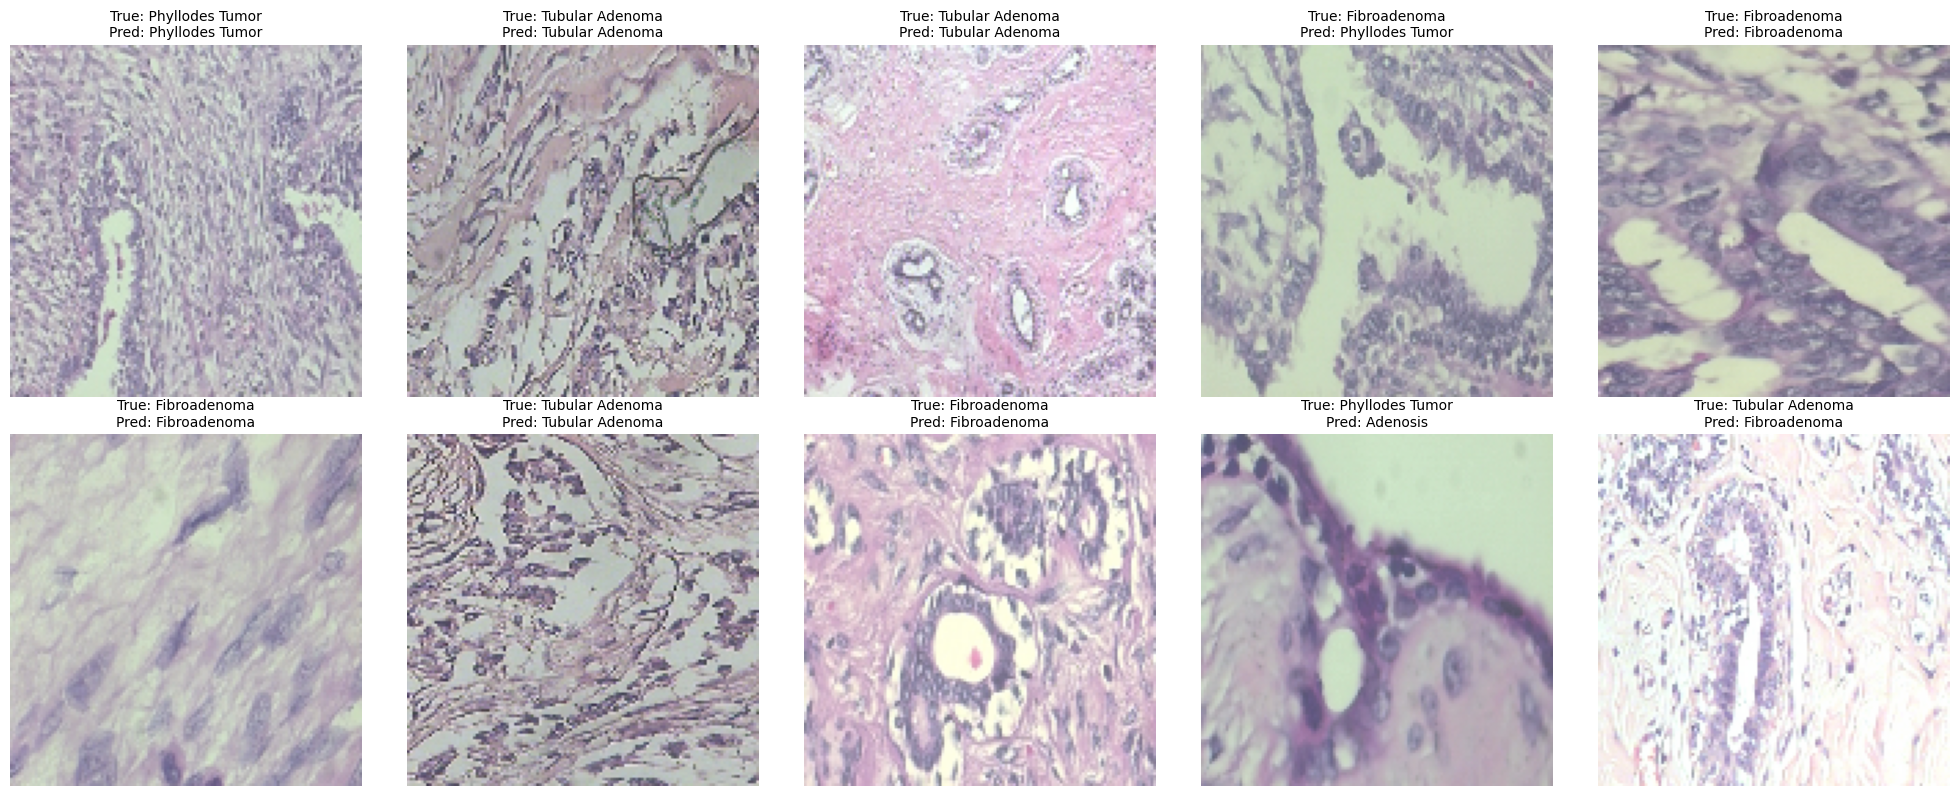

In [18]:
random_indices = random.sample(range(len(dataTest_b)), 10)
random_images = [dataTest_b[i][0] for i in random_indices]
true_labels = [dataTest_b[i][1] for i in random_indices]

image_batch = tf.stack(random_images)
predictions = benign_model.predict(image_batch)

predicted_labels = tf.argmax(predictions, axis=1).numpy()

label_map = {0: "Adenosis", 1: "Fibroadenoma", 2: "Phyllodes Tumor", 3: "Tubular Adenoma"}

plt.figure(figsize=(20, 8))
for i in range(10):
    img = image_batch[i].numpy()
    img = np.clip(img, 0, 1)
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {label_map[true_labels[i]]}\nPred: {label_map[predicted_labels[i]]}", fontsize=10)

plt.tight_layout()
plt.show()

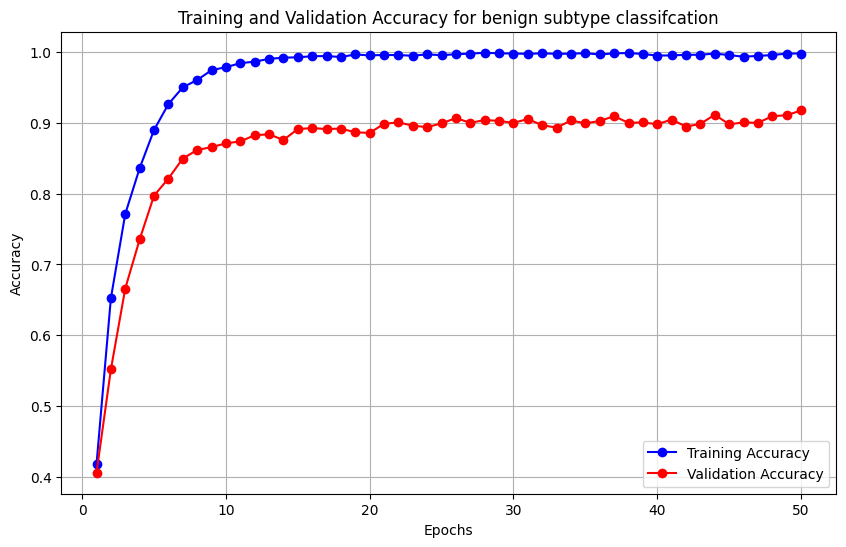

In [19]:
train_acc = history_b.history['accuracy']
val_acc = history_b.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for benign subtype classifcation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
y_true_b = []
y_pred_b = []

for images, labels in test_dataset_b:  
    predictions_b = benign_model.predict(images, verbose=0)
    predicted_classes_b = np.argmax(predictions_b, axis=1) 
    true_classes_b = np.argmax(labels, axis=1) 

    y_true_b.extend(true_classes_b)
    y_pred_b.extend(predicted_classes_b)

y_true_b = np.array(y_true_b)
y_pred_b = np.array(y_pred_b)

precision = precision_score(y_true_b, y_pred_b, average='macro')
recall = recall_score(y_true_b, y_pred_b, average='macro')
f1 = f1_score(y_true_b, y_pred_b, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9195
Recall: 0.8943
F1 Score: 0.9047


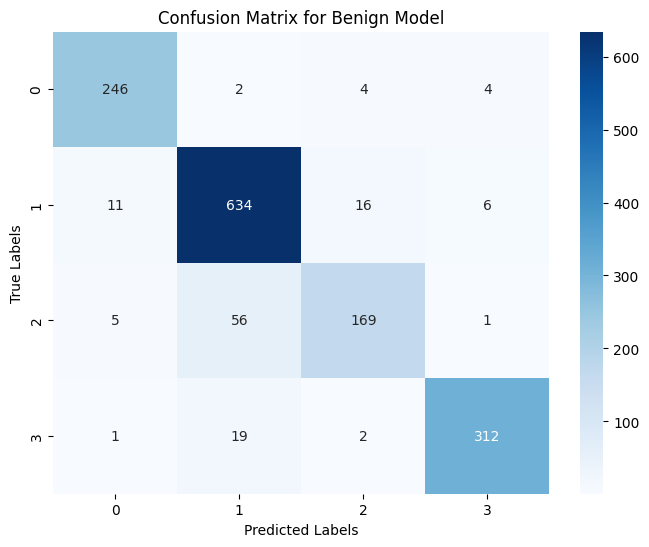

In [21]:
conf_matrix_b = confusion_matrix(y_true_b, y_pred_b)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_b, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix for Benign Model')
plt.show()

# Malignant Subtypes Classification 

## Training 3.0

In [22]:
base_model_m = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

layer_names = ['block3_sepconv2_act', 'block10_sepconv2_act', 'block13_sepconv2_act']
intermediate_outputs = [base_model_m.get_layer(name).output for name in layer_names]

intermediate_model = Model(inputs=base_model_m.input, outputs=intermediate_outputs)

branch_outputs = []
for output in intermediate_outputs:
    x = GlobalAveragePooling2D()(output)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    branch_outputs.append(x)

fusion = Concatenate()(branch_outputs)

x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(fusion)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
final_output = Dense(4, activation='softmax')(x) 

malignant_model = Model(inputs=base_model_m.input, outputs=final_output)

optimizer = Adam(learning_rate=0.0001)
malignant_model.compile(optimizer=optimizer,
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

malignant_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 63, 63, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 63, 63, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 63, 63, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 61, 61, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 61, 61, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 61, 61, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 61, 61, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 61, 61, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 61, 61, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 31, 31, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 31, 31, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 14,713,572 (56.13 MB)

 Trainable params: 14,669,892 (55.96 MB)

 Non-trainable params: 43,680 (170.62 KB)

In [23]:
import time

start_time = time.time()

history_m = malignant_model.fit(dataTrain_m,
                                validation_data=dataVal_m,
                                epochs=50)

end_time = time.time()

total_time = end_time - start_time
print(f"Total time taken to train the model: {total_time:.2f} seconds")

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 458ms/step - accuracy: 0.3714 - loss: 1.9536 - val_accuracy: 0.1843 - val_loss: 1.7387
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 0.6669 - loss: 1.1965 - val_accuracy: 0.1886 - val_loss: 1.6692
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 0.7932 - loss: 0.9026 - val_accuracy: 0.4310 - val_loss: 1.5037
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 0.8678 - loss: 0.7486 - val_accuracy: 0.6942 - val_loss: 1.3098
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 0.9049 - loss: 0.6549 - val_accuracy: 0.8311 - val_loss: 1.0720
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 0.9362 - loss: 0.5844 - val_accuracy: 0.8711 - val_loss: 0.8704
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - accuracy: 0.9468 - loss: 0.5513 - val_accuracy: 0.8839 - val_loss: 0.7503
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - accuracy: 0.9620 - loss: 0.5033 - val_accu

## Evaluation and Plots 3.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


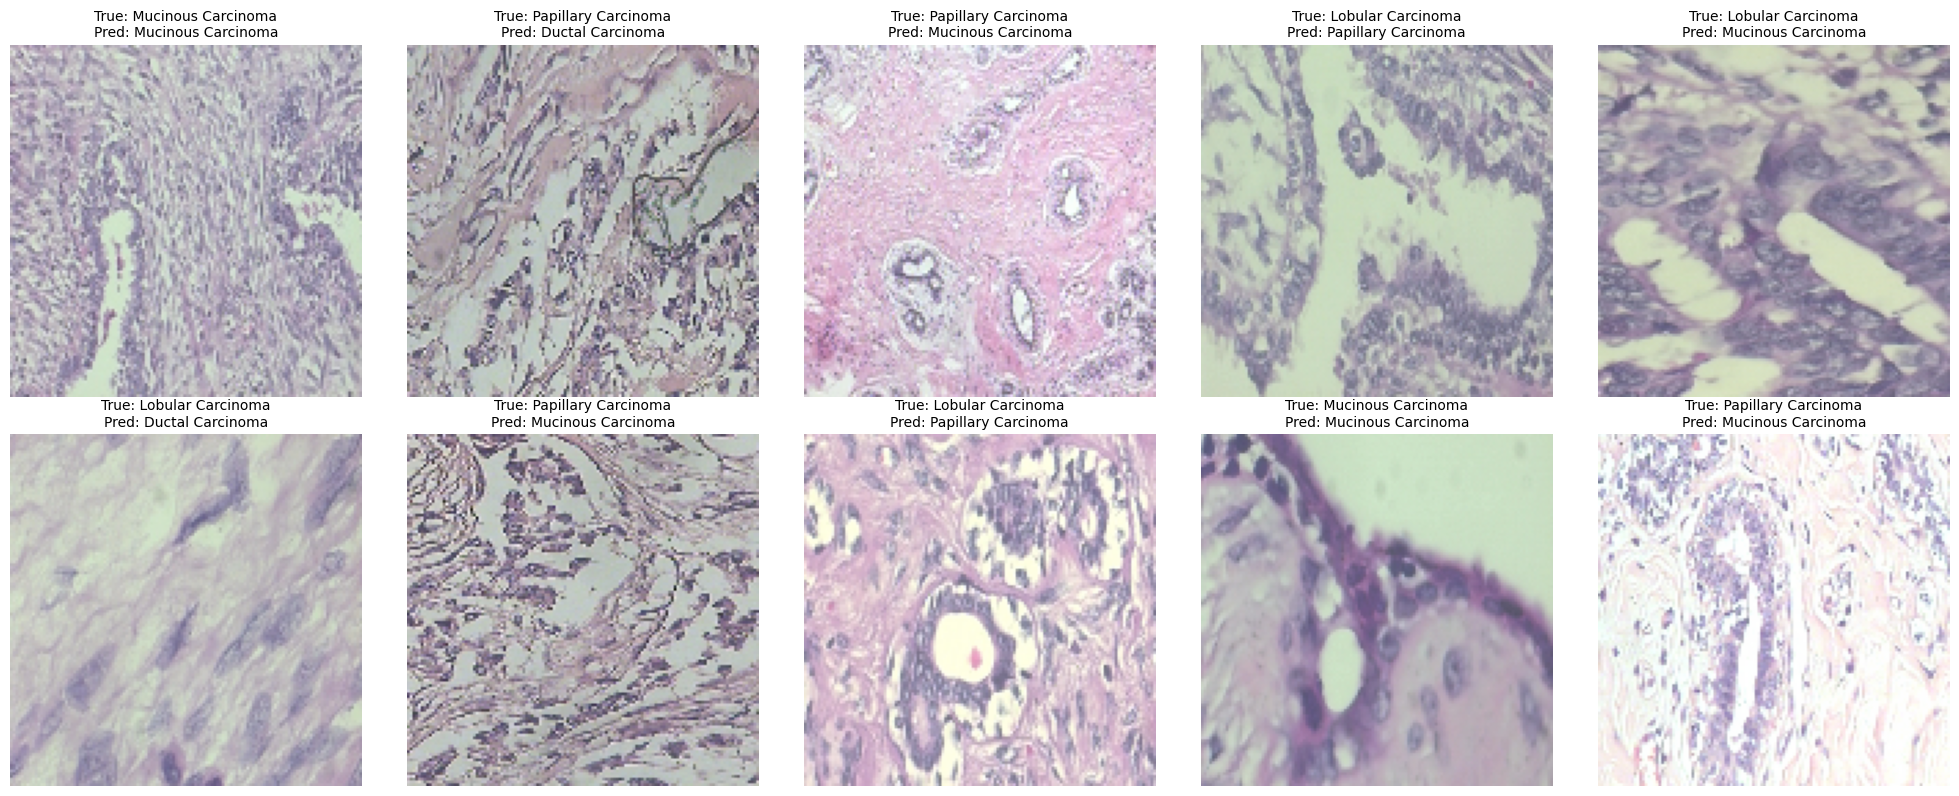

In [24]:
image_batch = tf.stack(random_images)

stacked_labels = tf.stack(true_labels).numpy()
if stacked_labels.ndim == 1:
    true_labels = stacked_labels
else:
    true_labels = np.argmax(stacked_labels, axis=1)

predictions = malignant_model.predict(image_batch)
predicted_labels = tf.argmax(predictions, axis=1).numpy()


label_map = {0: "Ductal Carcinoma", 1: "Lobular Carcinoma", 2: "Mucinous Carcinoma", 3: "Papillary Carcinoma"}

plt.figure(figsize=(20, 8))
for i in range(10):
    img = image_batch[i].numpy()
    img = np.clip(img, 0, 1)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {label_map[true_labels[i]]}\nPred: {label_map[predicted_labels[i]]}", fontsize=10)

plt.tight_layout()
plt.show()


In [25]:
train_loss, train_acc = malignant_model.evaluate(dataTrain_m )
print(f"Train accuracy -multi class for malignant-: {train_acc:.4f}")
test_loss, test_acc = malignant_model.evaluate(test_dataset_m)
print(f"Test accuracy -multi class for malignant-: {test_acc:.4f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9916 - loss: 0.1315
Train accuracy -multi class for malignant-: 0.9922
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9221 - loss: 0.4515
Test accuracy -multi class for malignant-: 0.9212


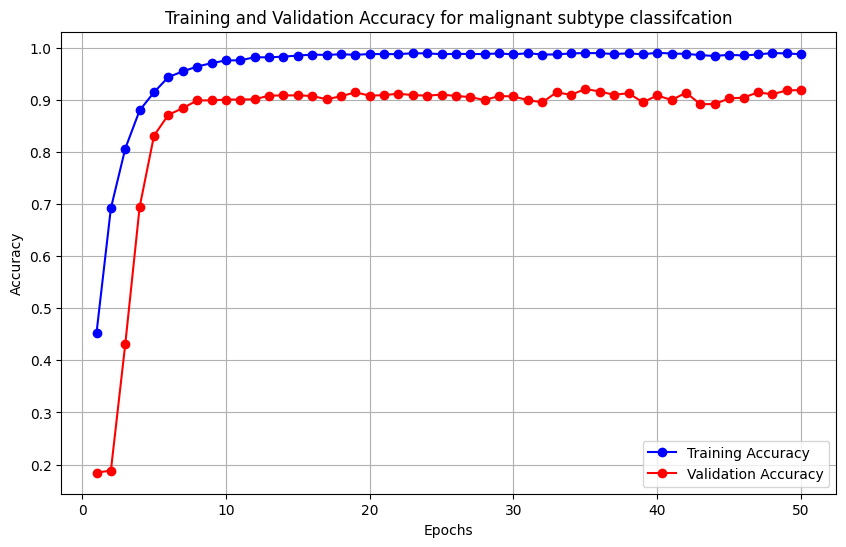

In [26]:
train_acc = history_m.history['accuracy']
val_acc = history_m.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for malignant subtype classifcation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
y_true_m = []
y_pred_m = []

for images, labels in test_dataset_m:  
    predictions_m = malignant_model.predict(images, verbose=0)
    predicted_classes_m = np.argmax(predictions_m, axis=1)
    true_classes_m = np.argmax(labels, axis=1)

    y_true_m.extend(true_classes_m)
    y_pred_m.extend(predicted_classes_m)

y_true_m = np.array(y_true_m)
y_pred_m = np.array(y_pred_m)

precision = precision_score(y_true_m, y_pred_m, average='macro')
recall = recall_score(y_true_m, y_pred_m, average='macro')
f1 = f1_score(y_true_m, y_pred_m, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9241
Recall: 0.9164
F1 Score: 0.9200


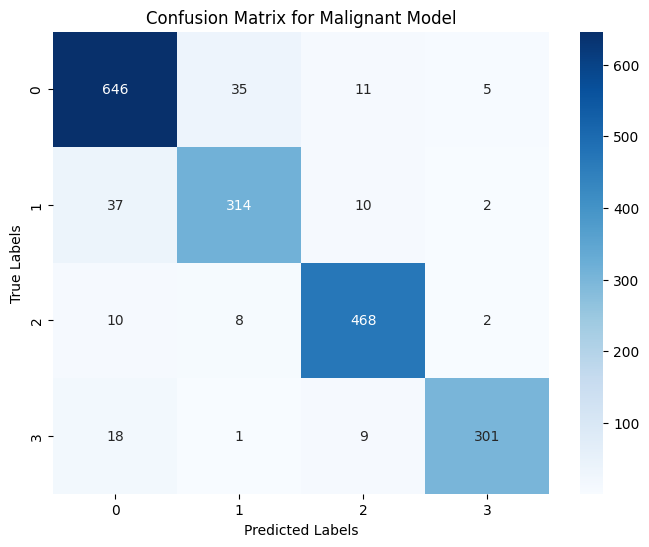

In [28]:
conf_matrix_m = confusion_matrix(y_true_m, y_pred_m)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_m, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix for Malignant Model')
plt.show()

# Thank You